Classification of radio signals into pulsars or non-pulsar using K-nearest neighbors

INTRODUCTION:

A pulsar is a highly magnetized rotating neutron star that emits beams of electromagnetic radiation out of its magnetic poles.

Since pulsars rotate rapidly, the emission of a pulsar forms a pattern that repeats periodically. This emission pattern varies slightly with each rotation and is unique for a pulsar. Therefore, the signal from a pulsar is averaged over many rotations giving us the fold/integrated profile of a pulsar. Since the Integrated pulse profile is unique to a pulsar it is also called a pulsar’s fingerprint.

In practice, most signals are due to radio frequency interference (RFI) and noise. Without additional information, all “candidate” signals collected by a radio telescope could be classified as pulsars. To help differentiate pulsars and non-pulsar signals, we also use the DM-SNR (Dispersion Measure vs Signal to Noise Ratio) curve for the signal.

Our question is: Given a new candidate signal, can we classify it as a pulsar or non-pulsar?

We use the HTRU2 data set available at the UCL machine learning repository. In this dataset, we use characteristics such as mean, standard deviation, excess kurtosis, and skewness for both the integrated profile and DM-SNR curve of a signal. For each candidate signal, there is a class label which classifies the detection as either a pulsar(1) or non-pulsar(0); a human annotator has classified the signals.


In [1]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [13]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(GGally)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)
options(repr.plot.height = 9, repr.plot.width = 9)

In [14]:
# Column names are:
# M_IP -> Mean of the Integrated Profile
# SD_IP -> Standard deviation of the Integrated Profile
# EK_IP -> Excess kurtosis of the Integrated Profile
# SK_IP -> Skewness of the Integrated Profile
# M_DM_SNR -> Mean of the DM-SNR curve
# SD_DM_SNR -> Standard deviation of the DM-SNR curve
# EK_DM_SNR -> Excess kurtosis of the DM-SNR curve
# SK_DM_SNR -> Skewness of the DM-SNR curve
# CLASS -> Label for an observation pulsar(1) and non-pulsar(0)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "pulsar_data.zip")
unzip("pulsar_data.zip")
pulsar <- read_csv("HTRU_2.csv", 
                   col_names = c("M_IP","SD_IP","EK_IP","SK_IP","M_DM_SNR","SD_DM_SNR","EK_DM_SNR","SK_DM_SNR","CLASS")) |>
                mutate(CLASS = as_factor(CLASS))
pulsar
# CLASS variable is converted from double to factor type with two levels
# The data is tidy

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): M_IP, SD_IP, EK_IP, SK_IP, M_DM_SNR, SD_DM_SNR, EK_DM_SNR, SK_DM_SN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [4]:
# Mean value for each variable for each class
# Number of observations in each class
pulsar_summarize <- pulsar|>
            group_by(CLASS)|>
            summarize(count = n(),
                      across(M_IP:SK_DM_SNR, mean))
pulsar_summarize

CLASS,count,M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,16259,116.56273,47.33974,0.2104401,0.380844,8.863258,23.28798,8.862674,113.62034
1,1639,56.69061,38.71060,3.1306554,15.553576,49.825995,56.46896,2.757069,17.93173


This data set contains 16259 observations for non-pulsars and 1639 observations for pulsars. This illustrates that most of the radio signals are non-pulsar making pulsars hard to find.

In [5]:
# NA values in each column
pulsar_na <- pulsar|>
             map_dfr( ~ sum(is.na(.)))
pulsar_na

M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0


We can see that there are no NA values in this data set.

The following histograms show the distribution of variables for pulsars and non-pulsars:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



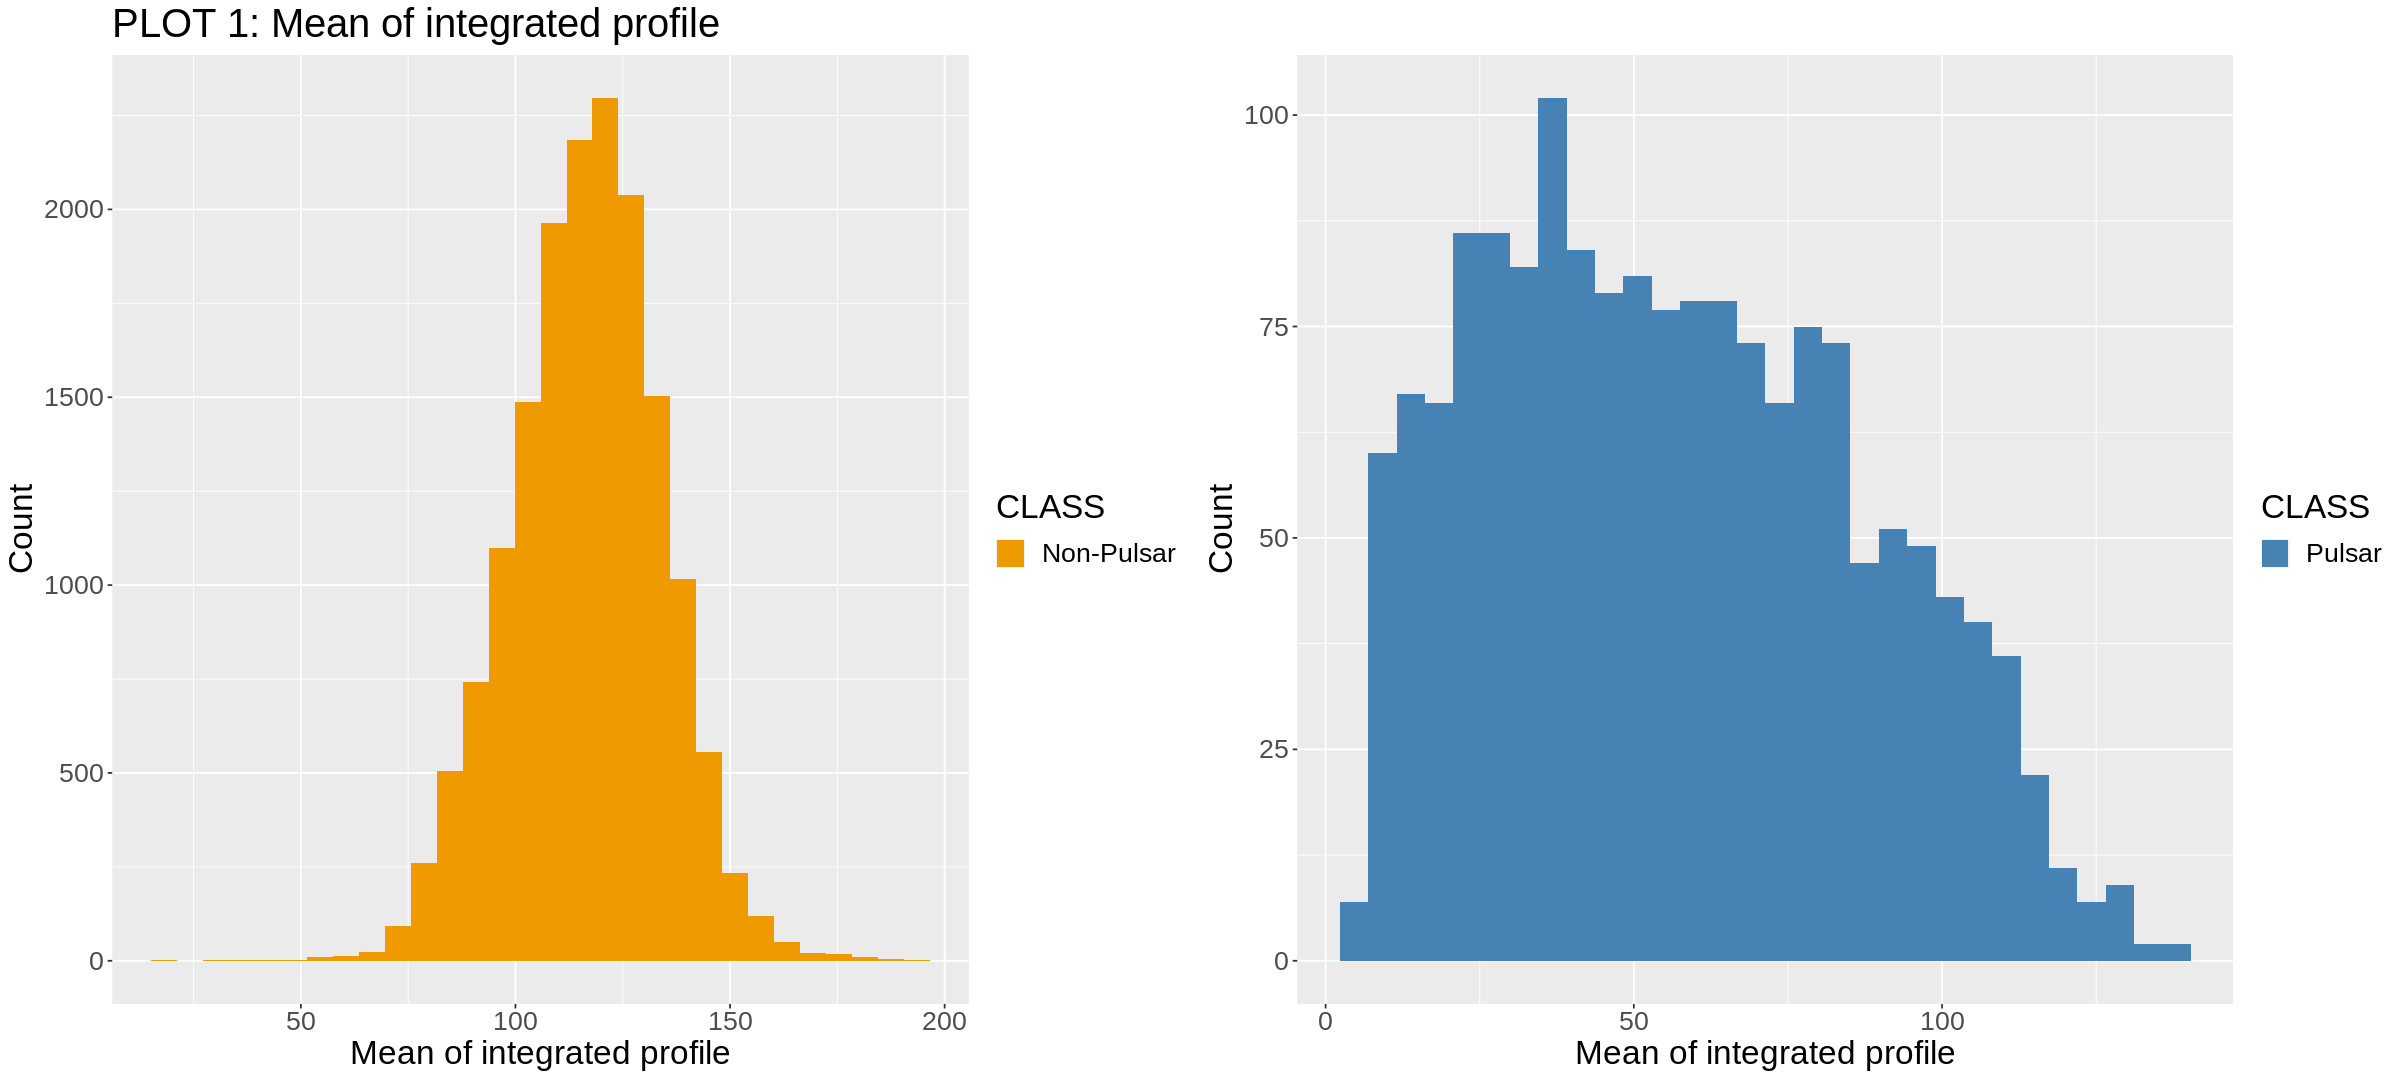

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



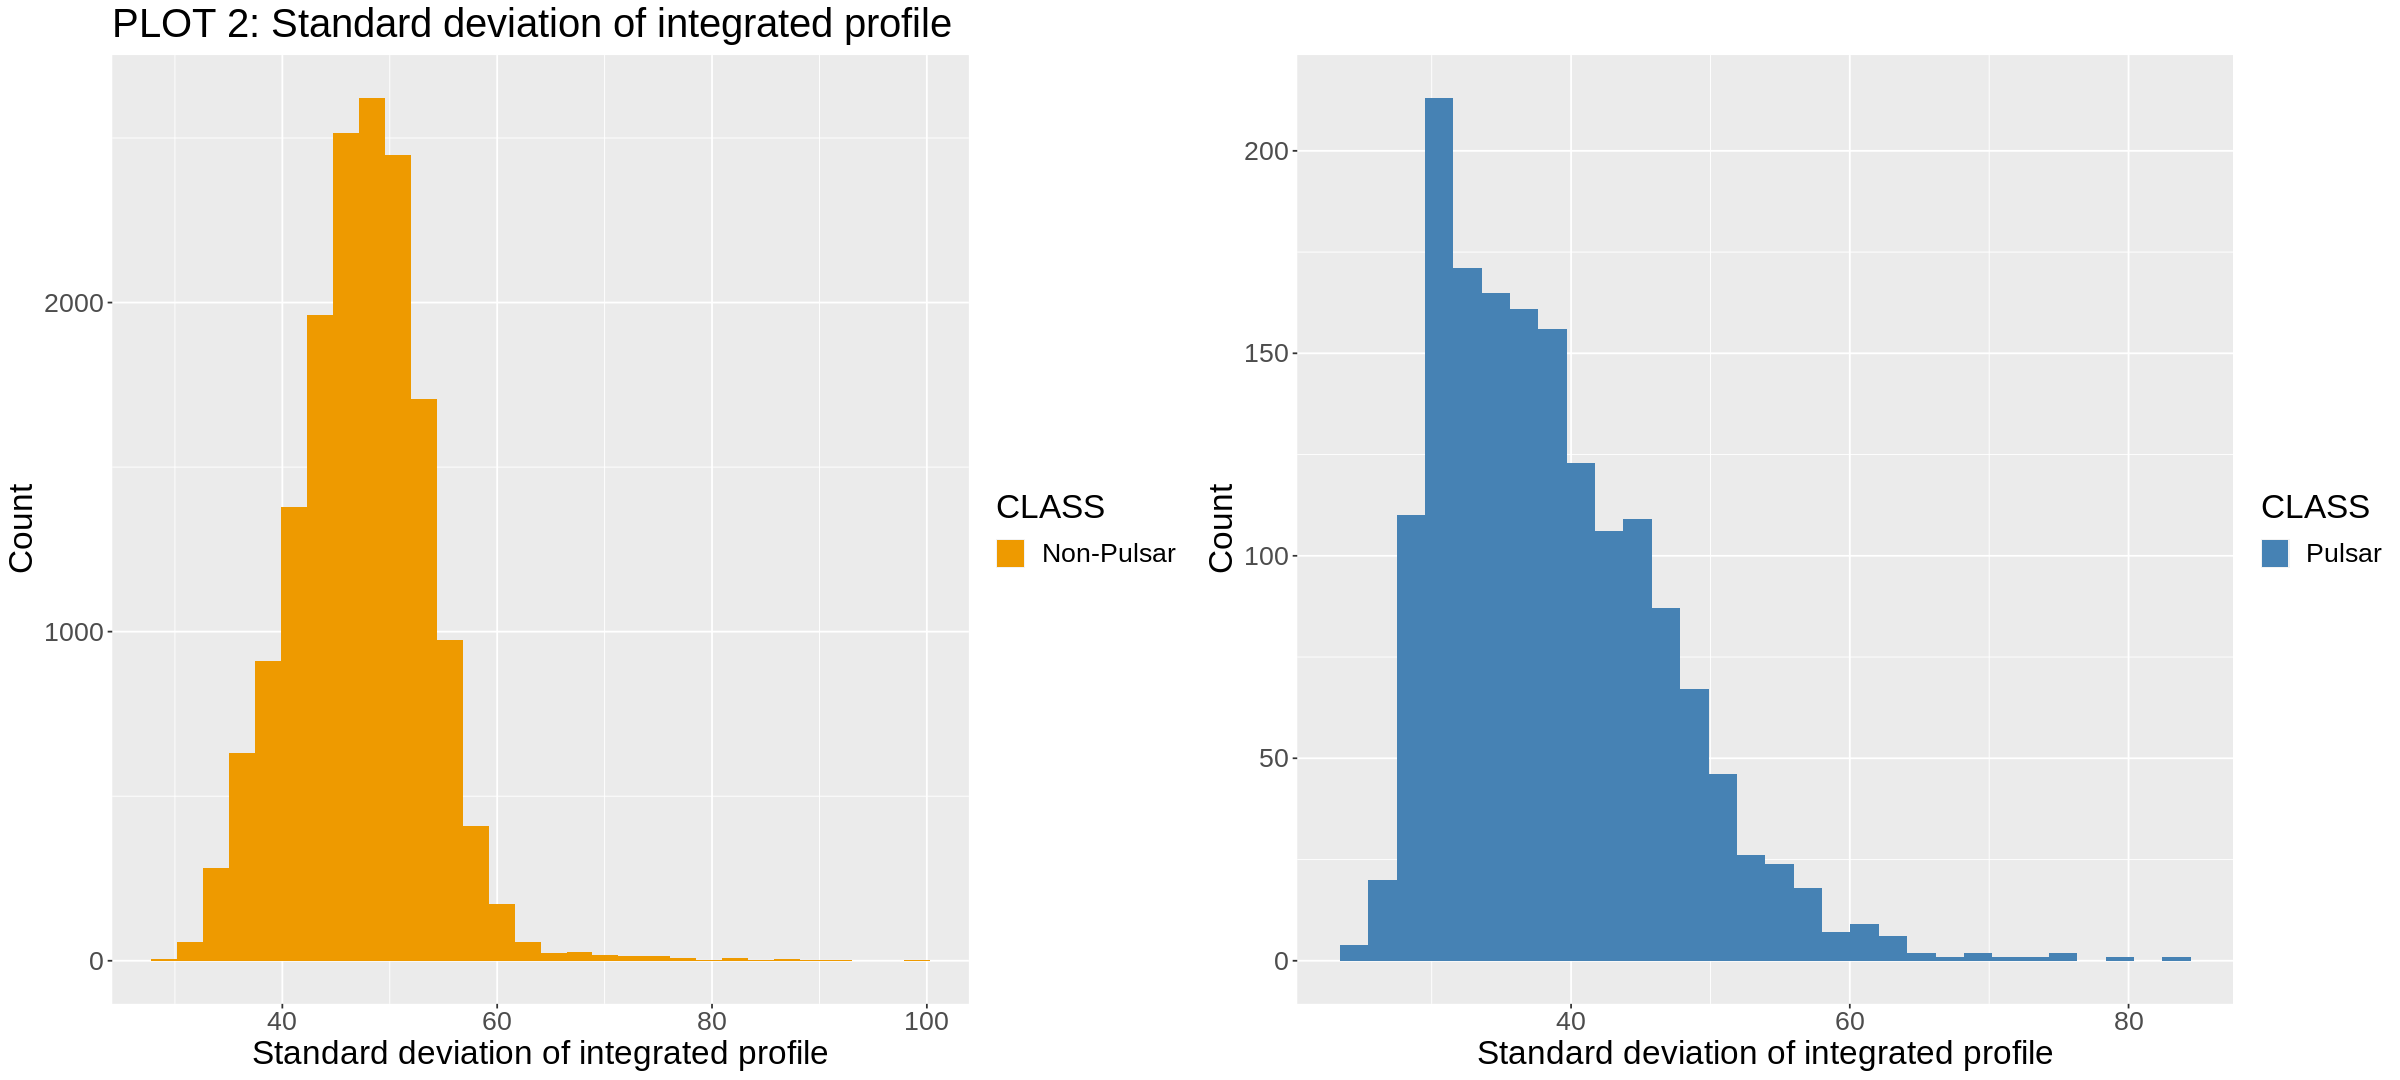

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



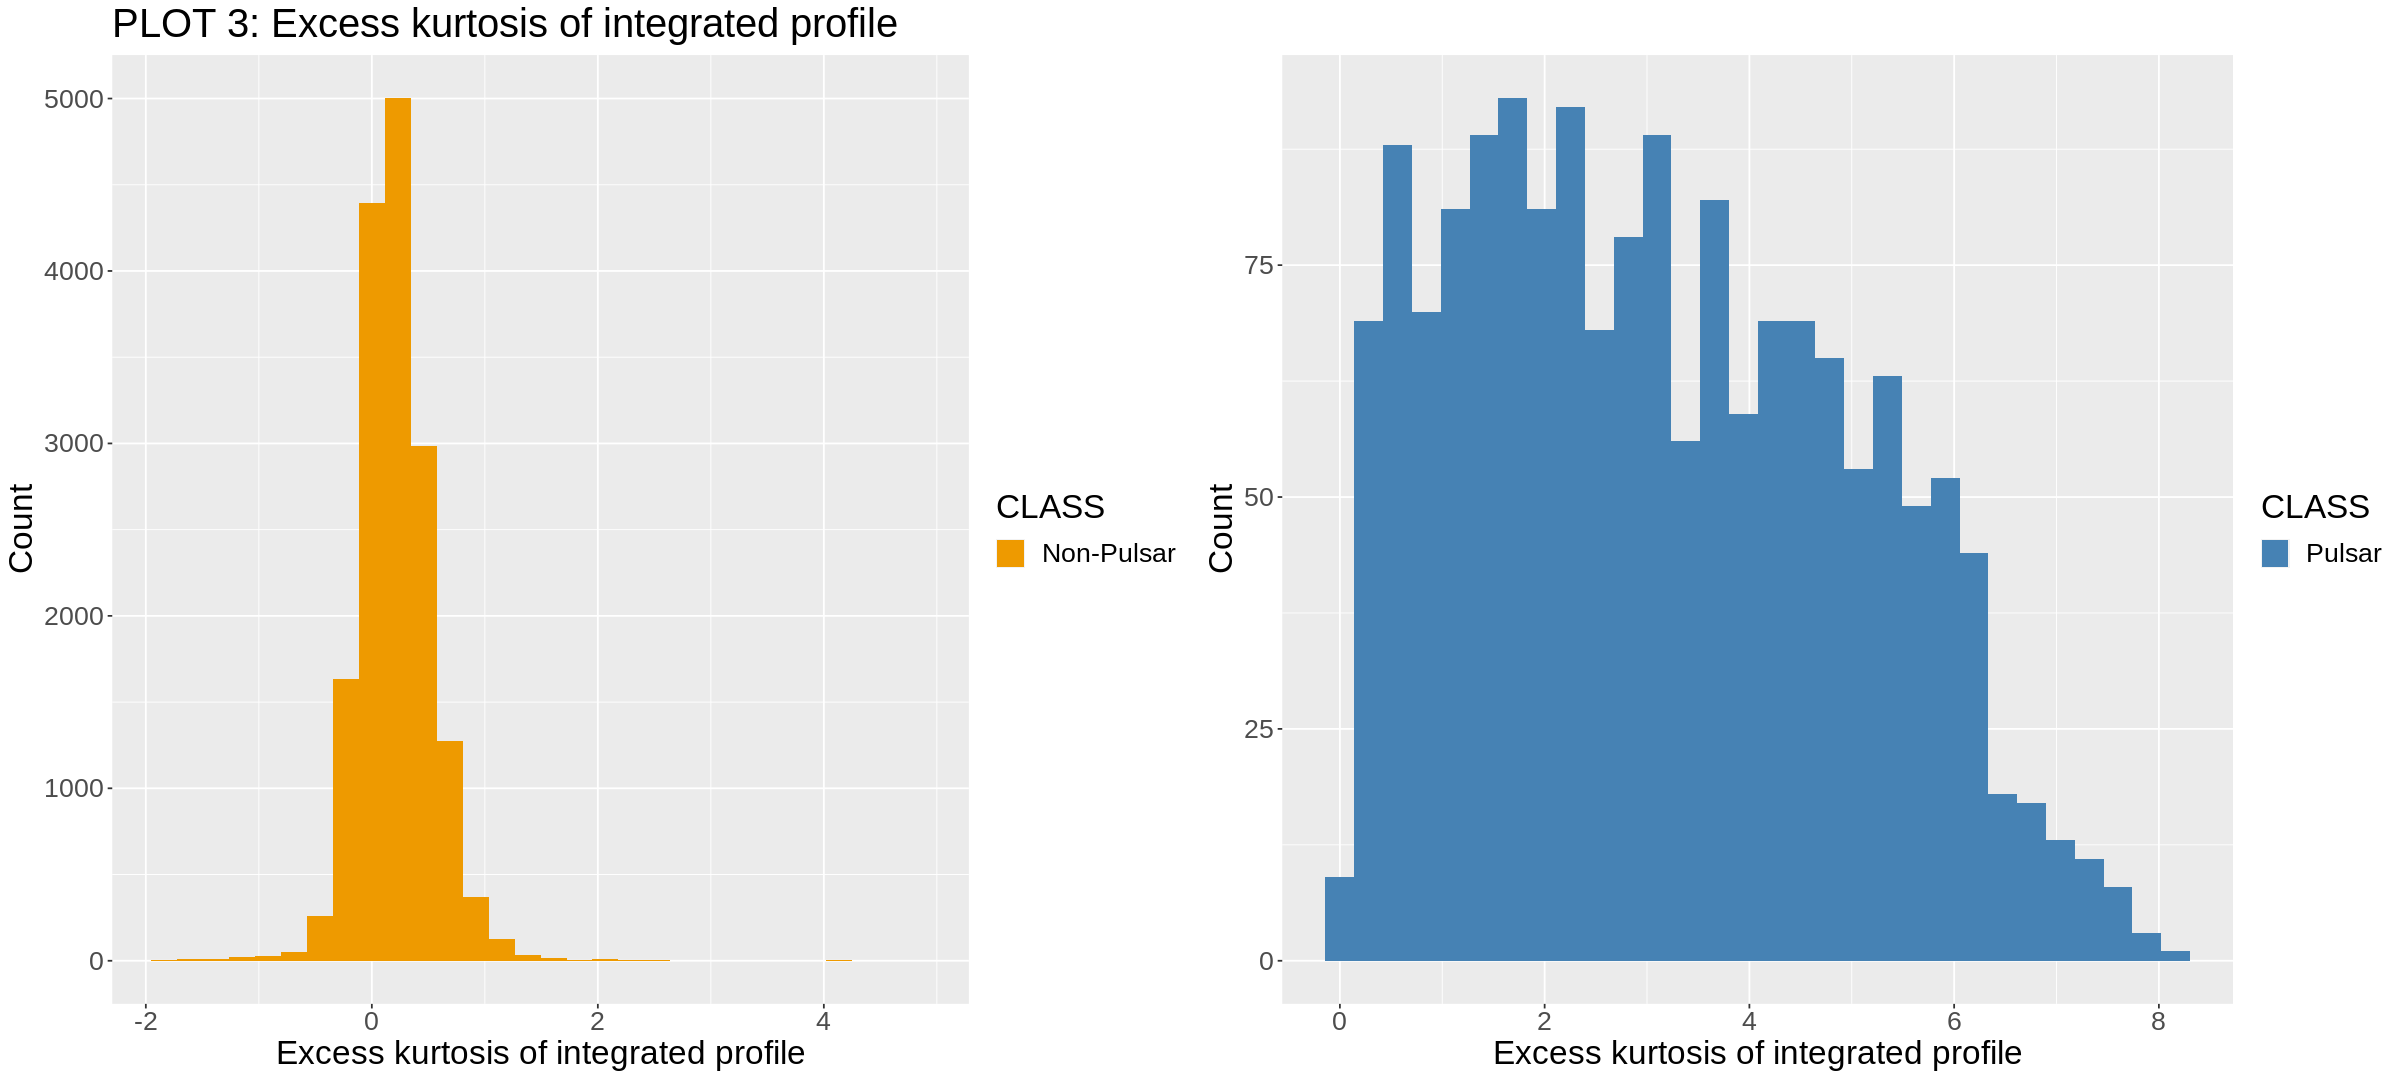

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



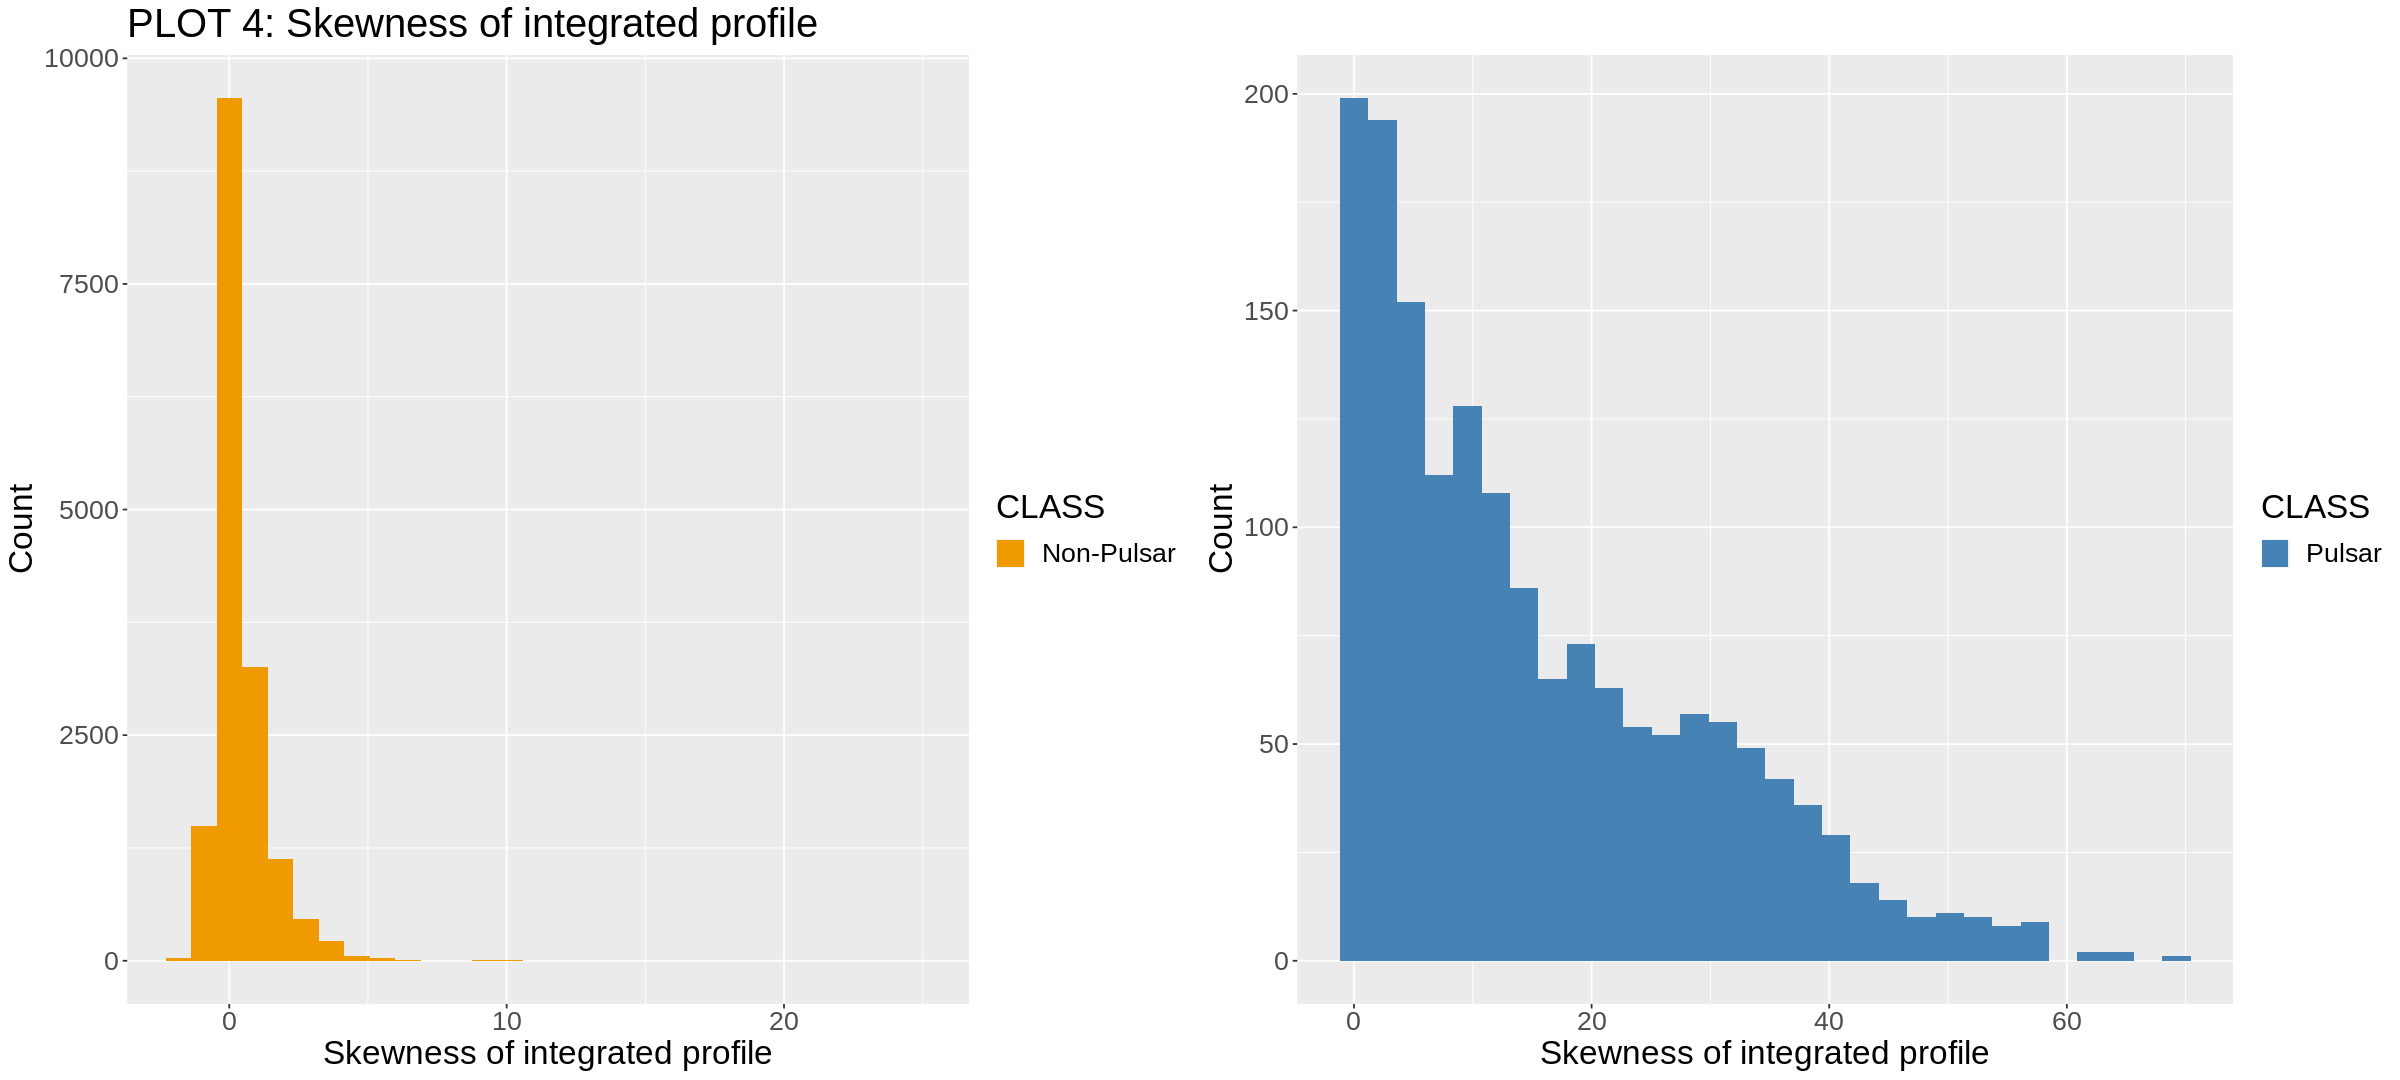

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



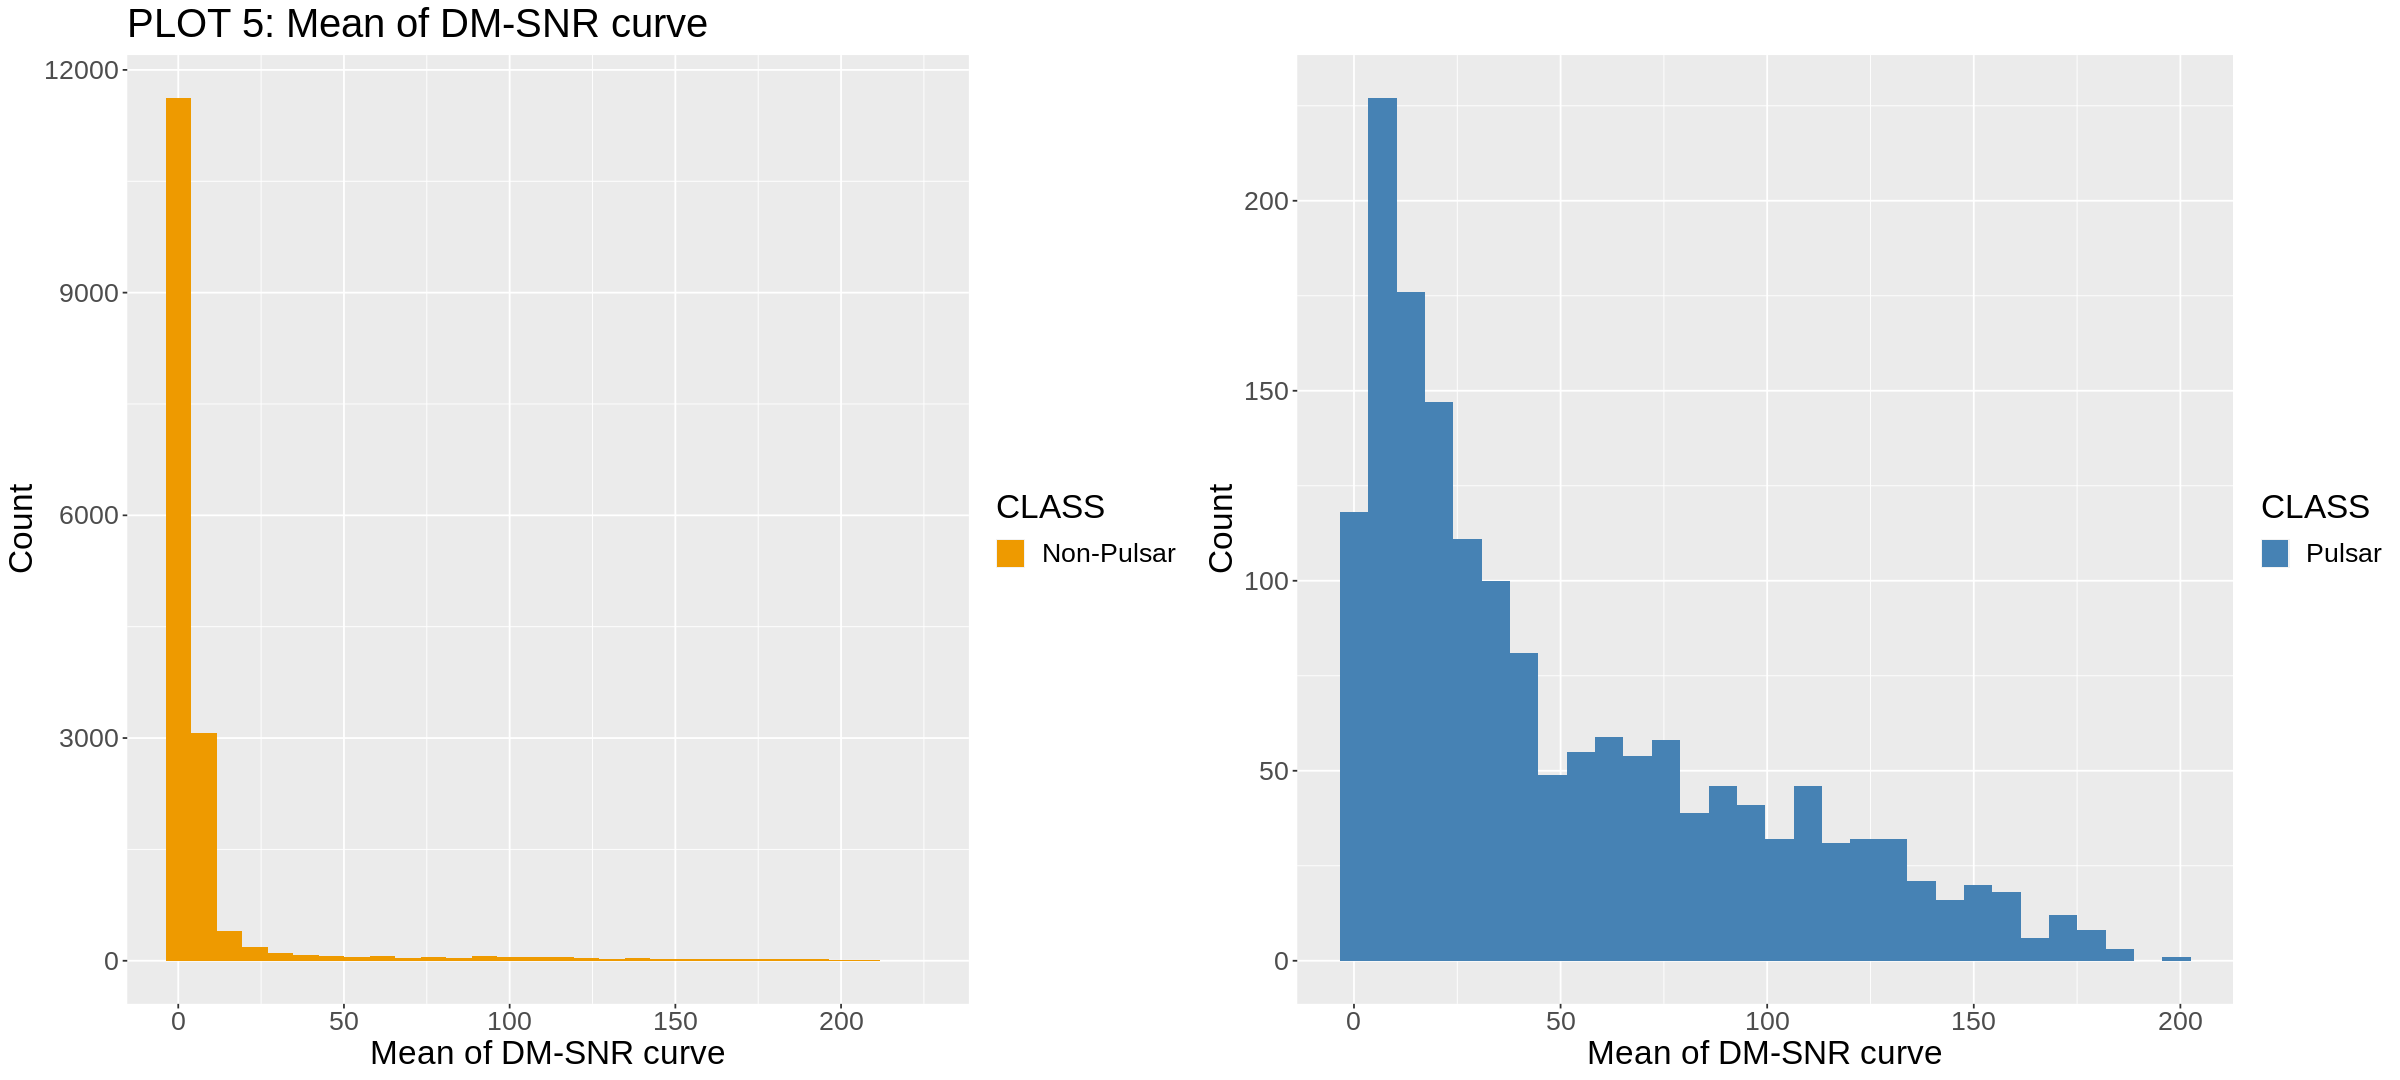

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



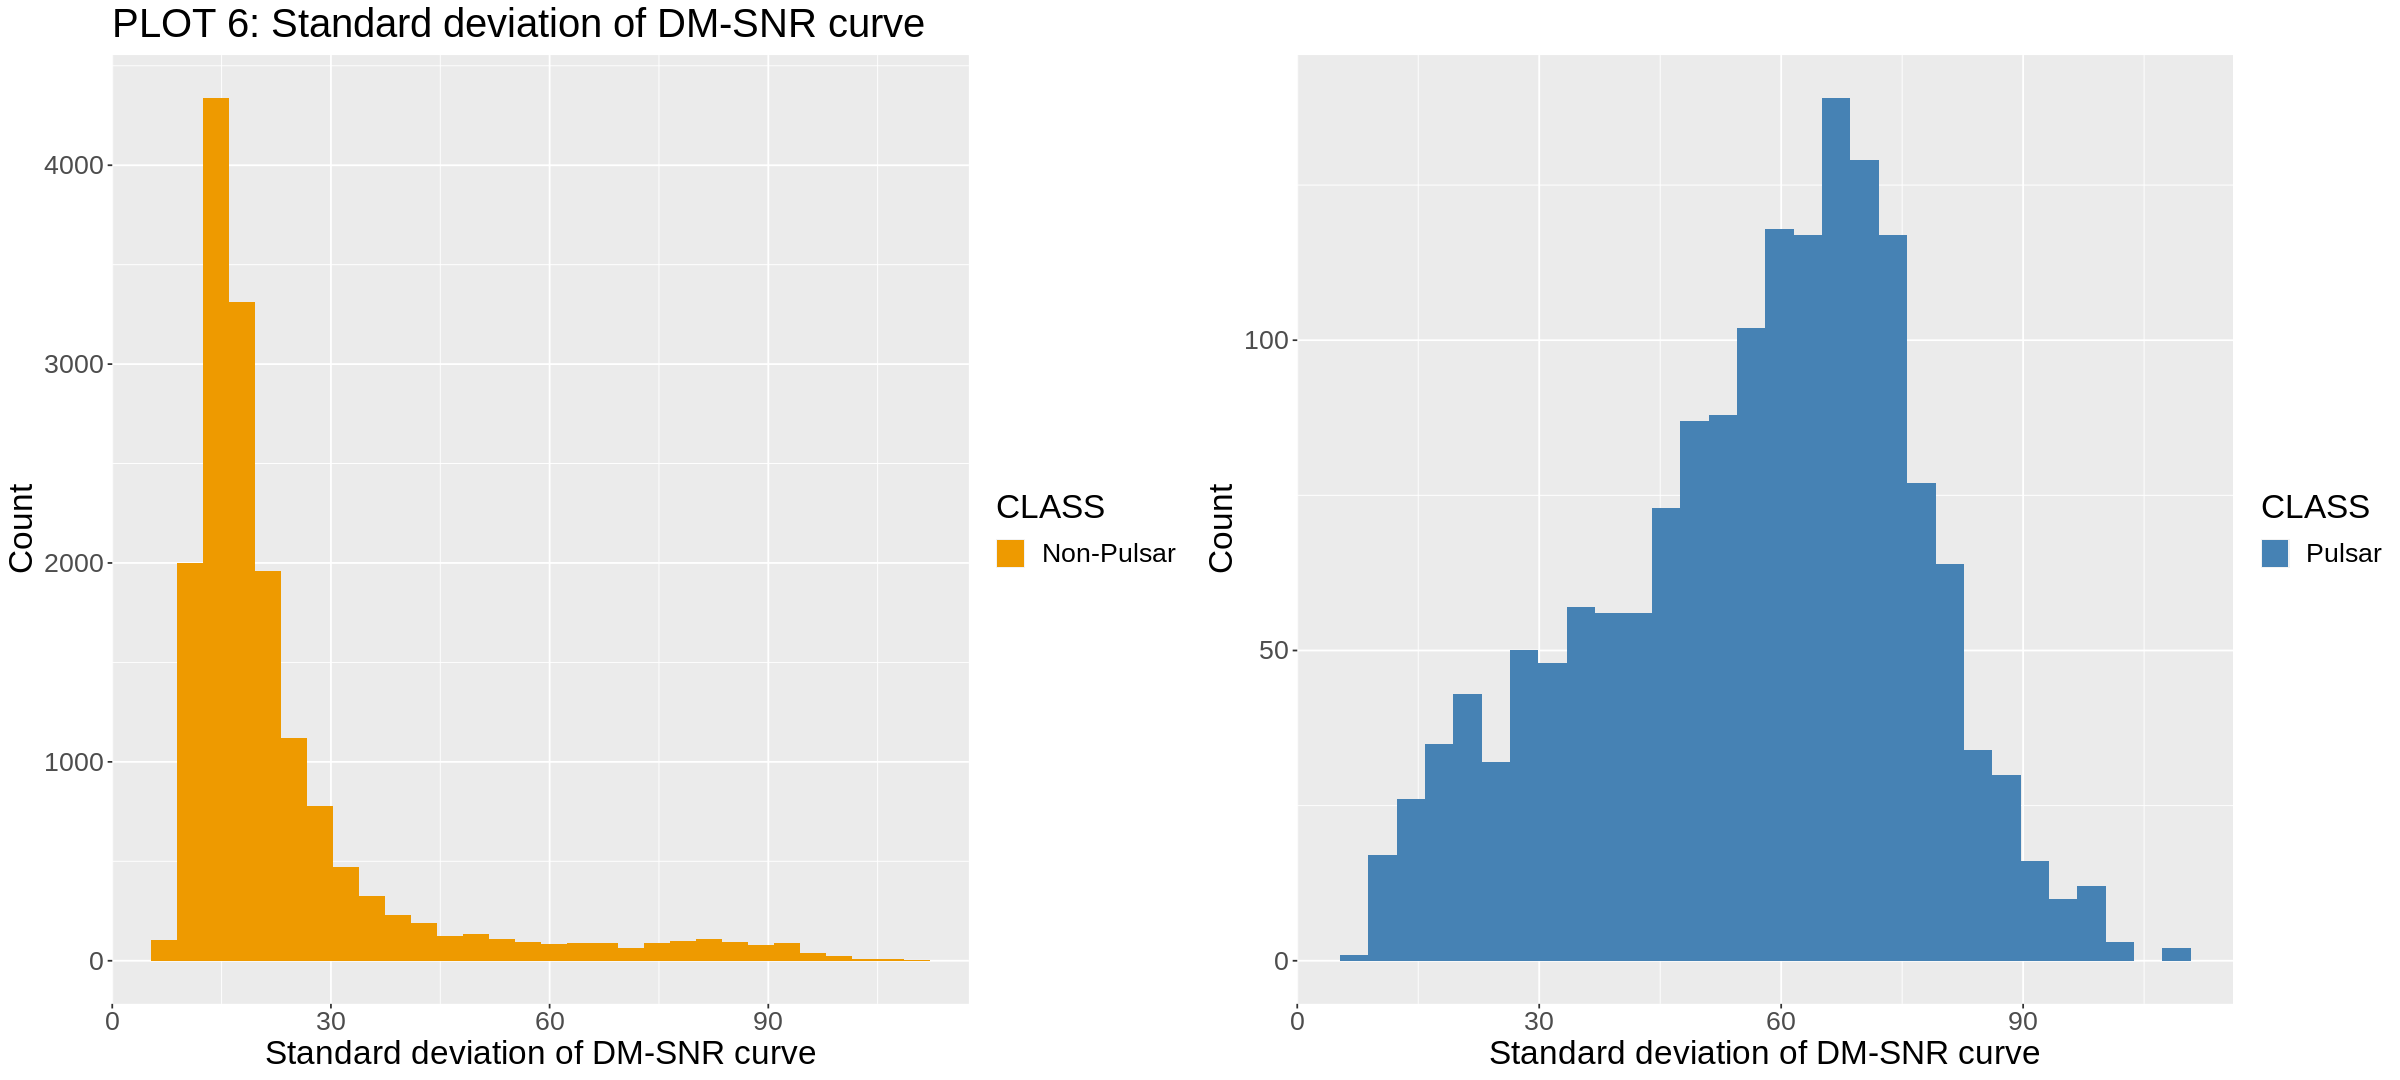

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



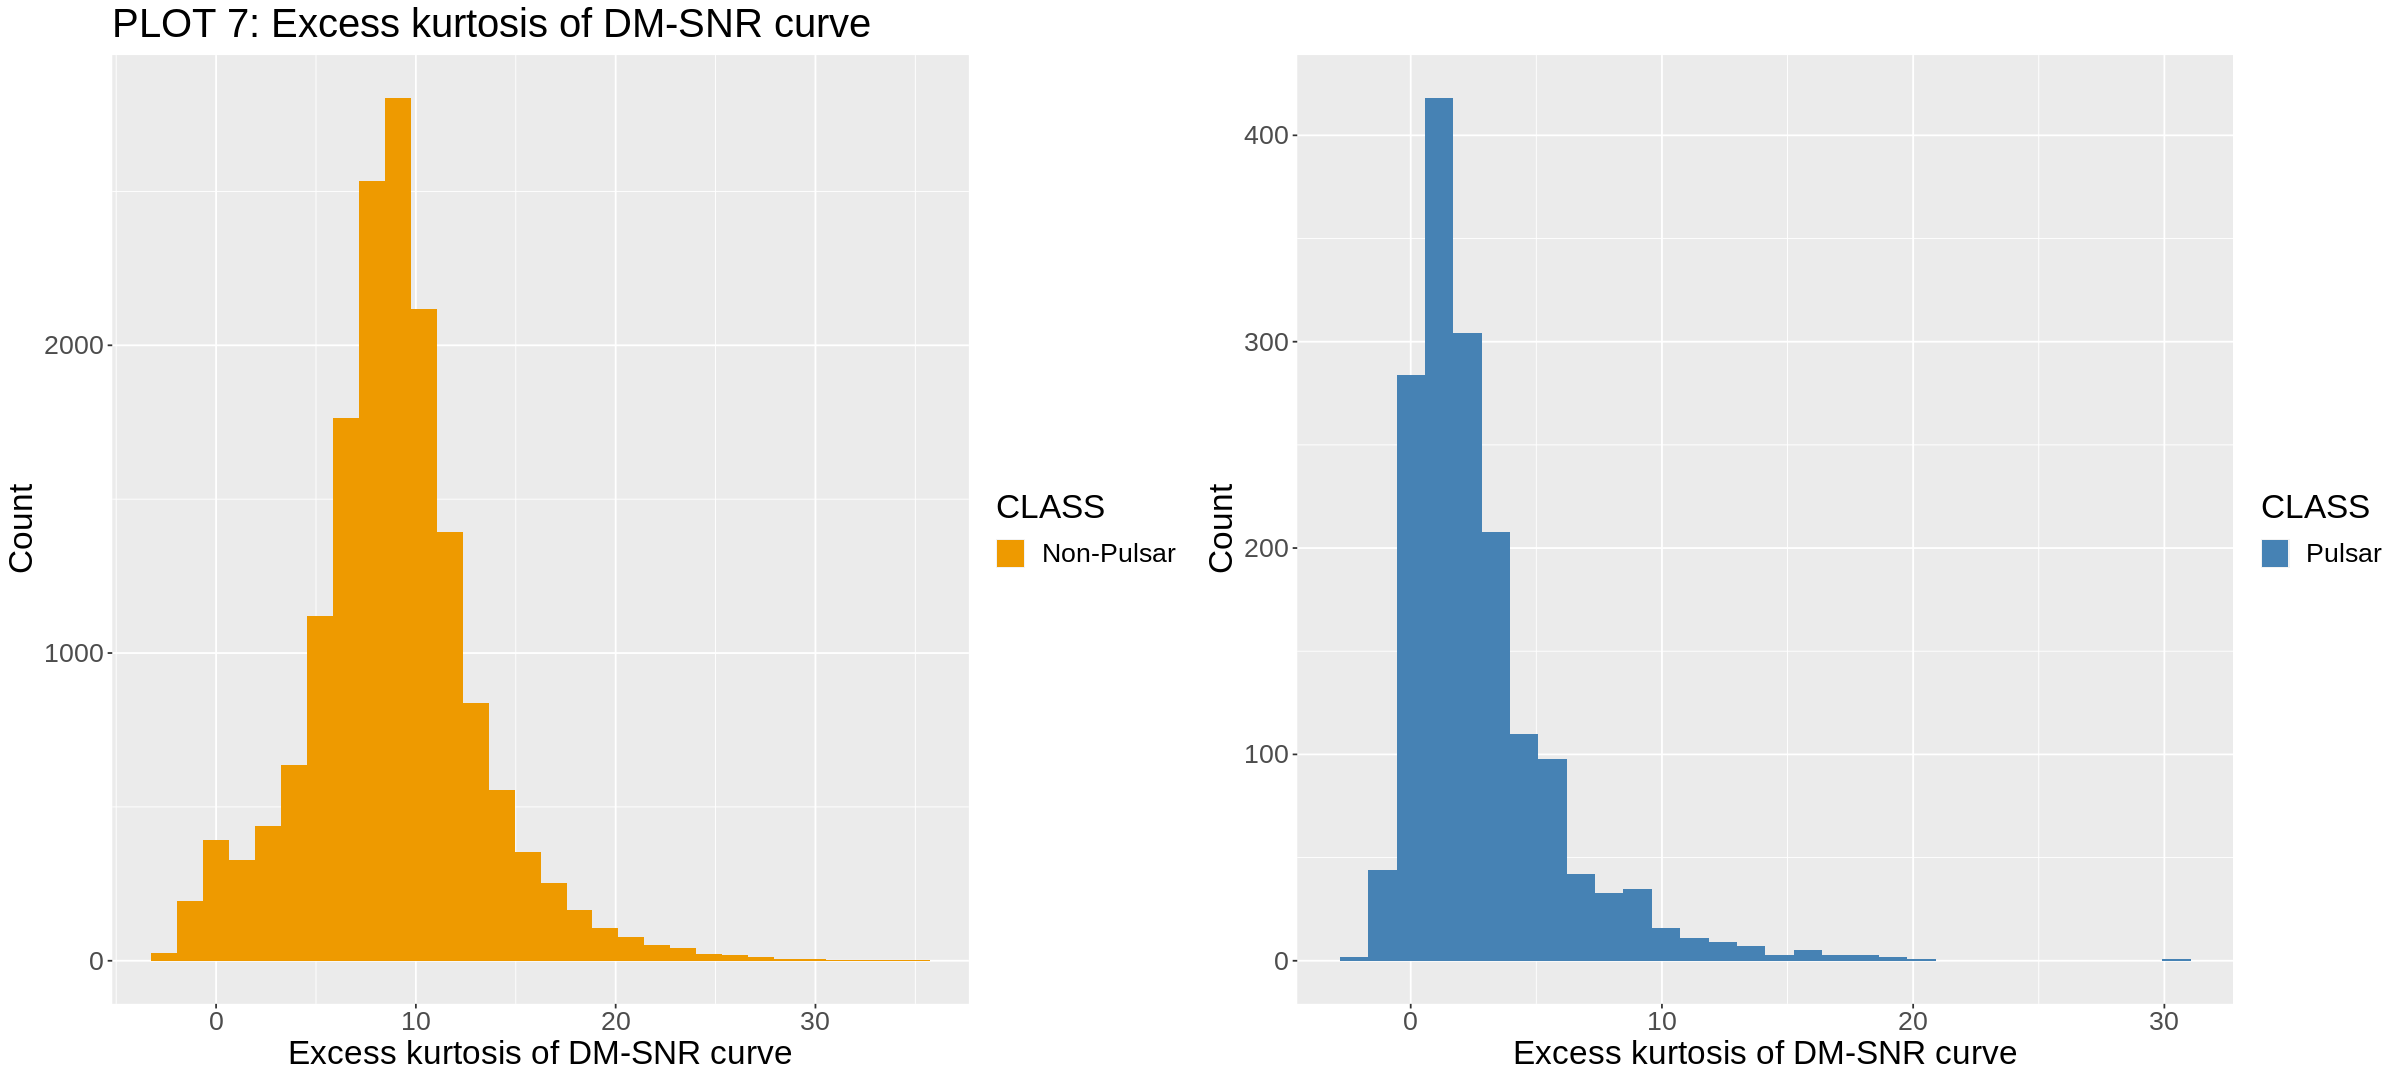

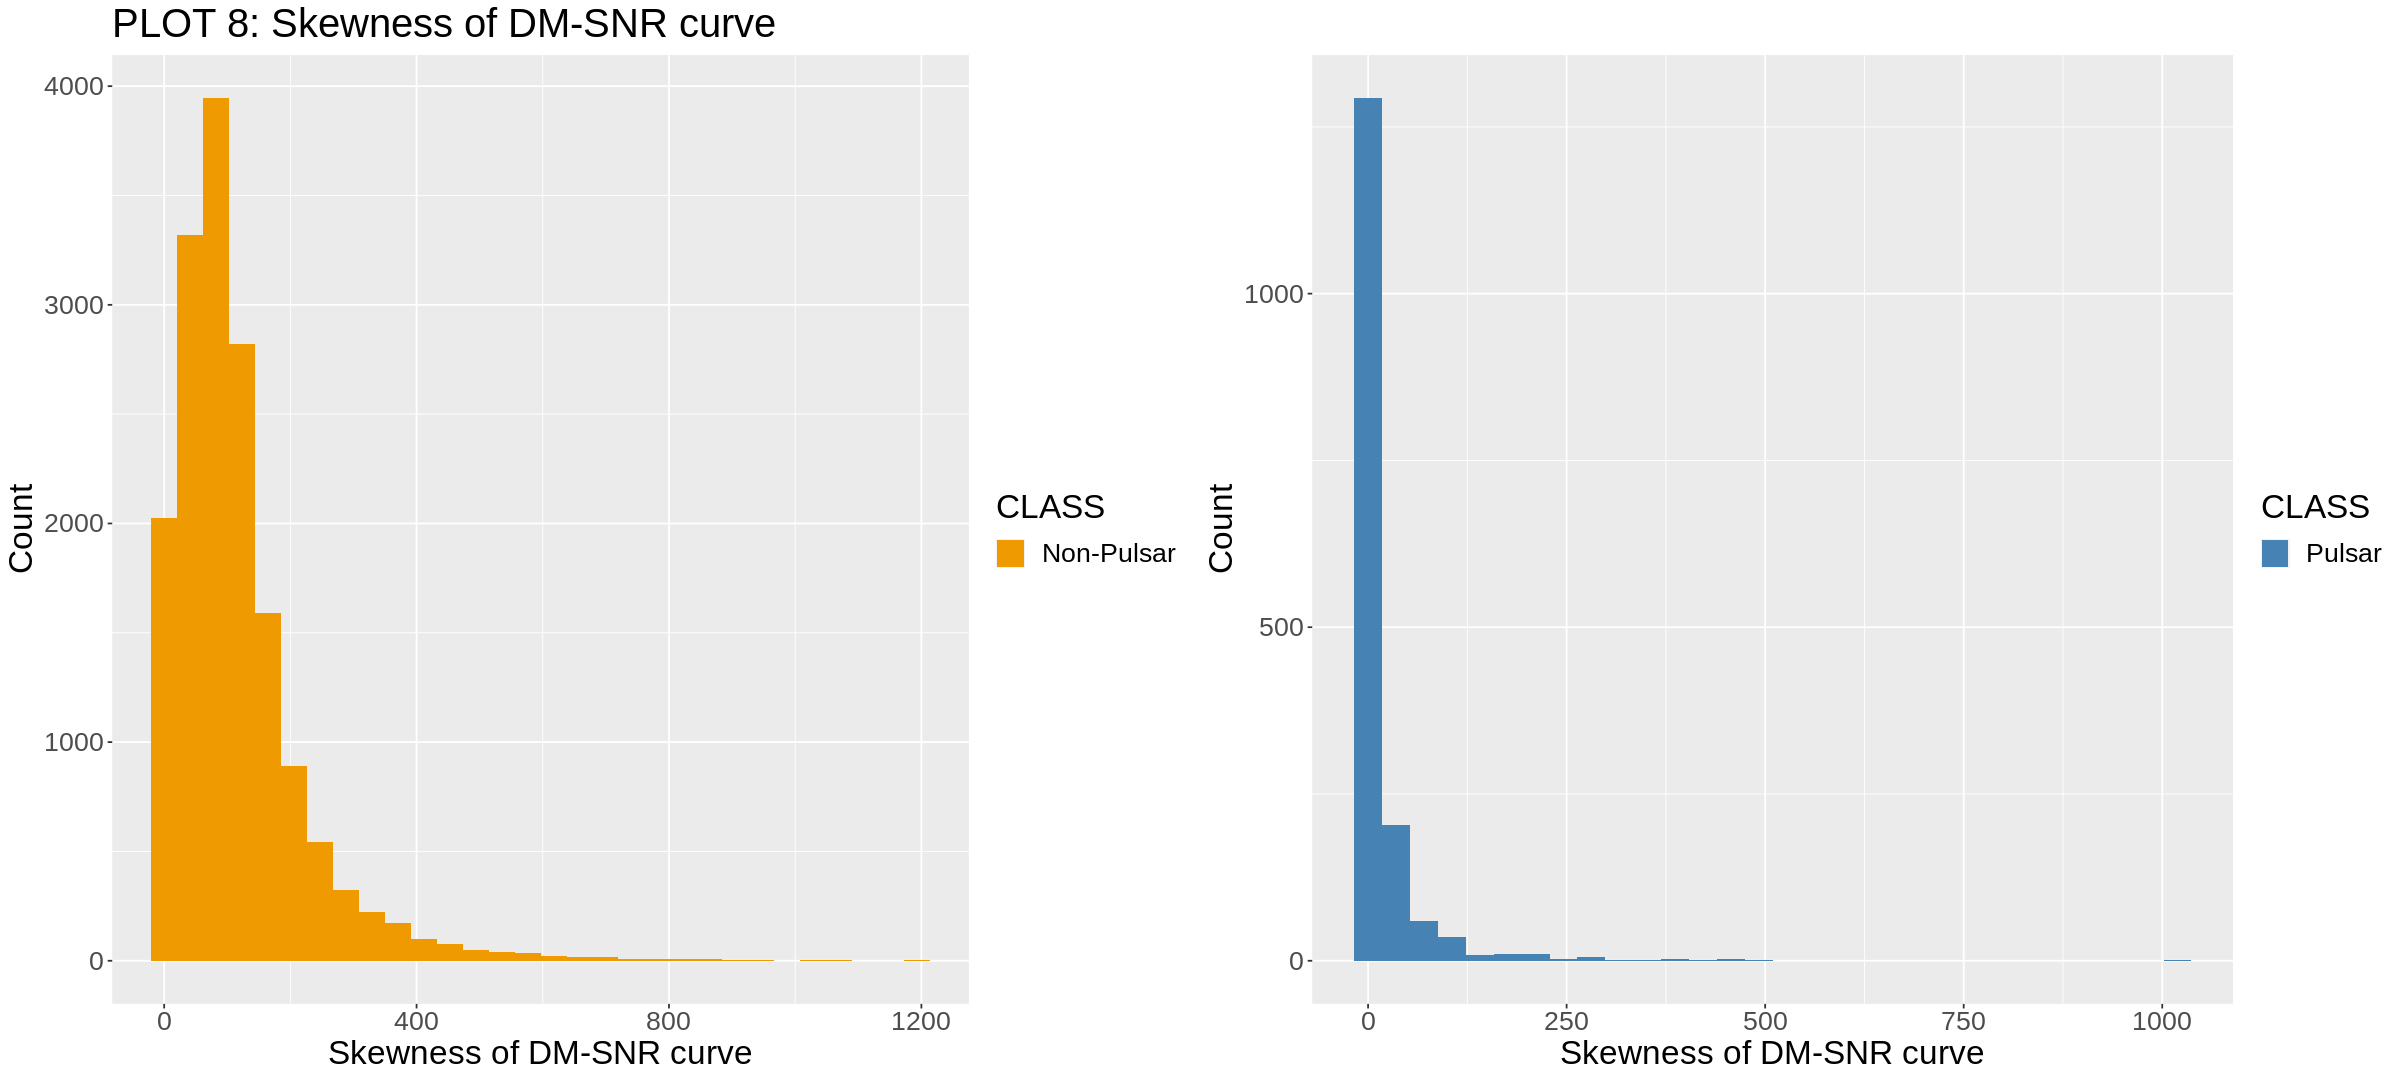

In [40]:
options(repr.plot.height = 9, repr.plot.width = 20)

pulsar_data_1 <- pulsar|>
              group_by(CLASS)|>
              select(M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS)|>
              filter(CLASS == 1)

pulsar_data_2 <- pulsar|>
              group_by(CLASS)|>
              select(M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS)|>
              filter(CLASS == 0)

plot_1 <- pulsar_data_1 |>
          ggplot(aes(x = M_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_2 <- pulsar_data_2 |>
          ggplot(aes(x = M_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 1: Mean of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_2, plot_1,ncol = 2)

plot_3 <- pulsar_data_1 |>
          ggplot(aes(x = SD_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_4 <- pulsar_data_2 |>
          ggplot(aes(x = SD_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 2: Standard deviation of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_4, plot_3,ncol = 2)

plot_5 <- pulsar_data_1 |>
          ggplot(aes(x = EK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_6 <- pulsar_data_2 |>
          ggplot(aes(x = EK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 3: Excess kurtosis of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_6, plot_5,ncol = 2)

plot_7 <- pulsar_data_1 |>
          ggplot(aes(x = SK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("")+
          theme(text = element_text(size = 20))
plot_8 <- pulsar_data_2 |>
          ggplot(aes(x = SK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 4: Skewness of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_8, plot_7,ncol = 2)

plot_9 <- pulsar_data_1 |>
          ggplot(aes(x = M_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_10 <- pulsar_data_2 |>
          ggplot(aes(x = M_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 5: Mean of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_10, plot_9,ncol = 2)

plot_11 <- pulsar_data_1 |>
          ggplot(aes(x = SD_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_12 <- pulsar_data_2 |>
          ggplot(aes(x = SD_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 6: Standard deviation of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_12, plot_11,ncol = 2)

plot_13 <- pulsar_data_1 |>
          ggplot(aes(x = EK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_14 <- pulsar_data_2 |>
          ggplot(aes(x = EK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 7: Excess kurtosis of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_14, plot_13,ncol = 2)

plot_15 <- pulsar_data_1 |>
          ggplot(aes(x = SK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_16 <- pulsar_data_2 |>
          ggplot(aes(x = SK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 8: Skewness of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_16, plot_15,ncol = 2)

In [4]:
set.seed(4)
pulsar_split <- initial_split(pulsar, prop = 0.8, strata = CLASS)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



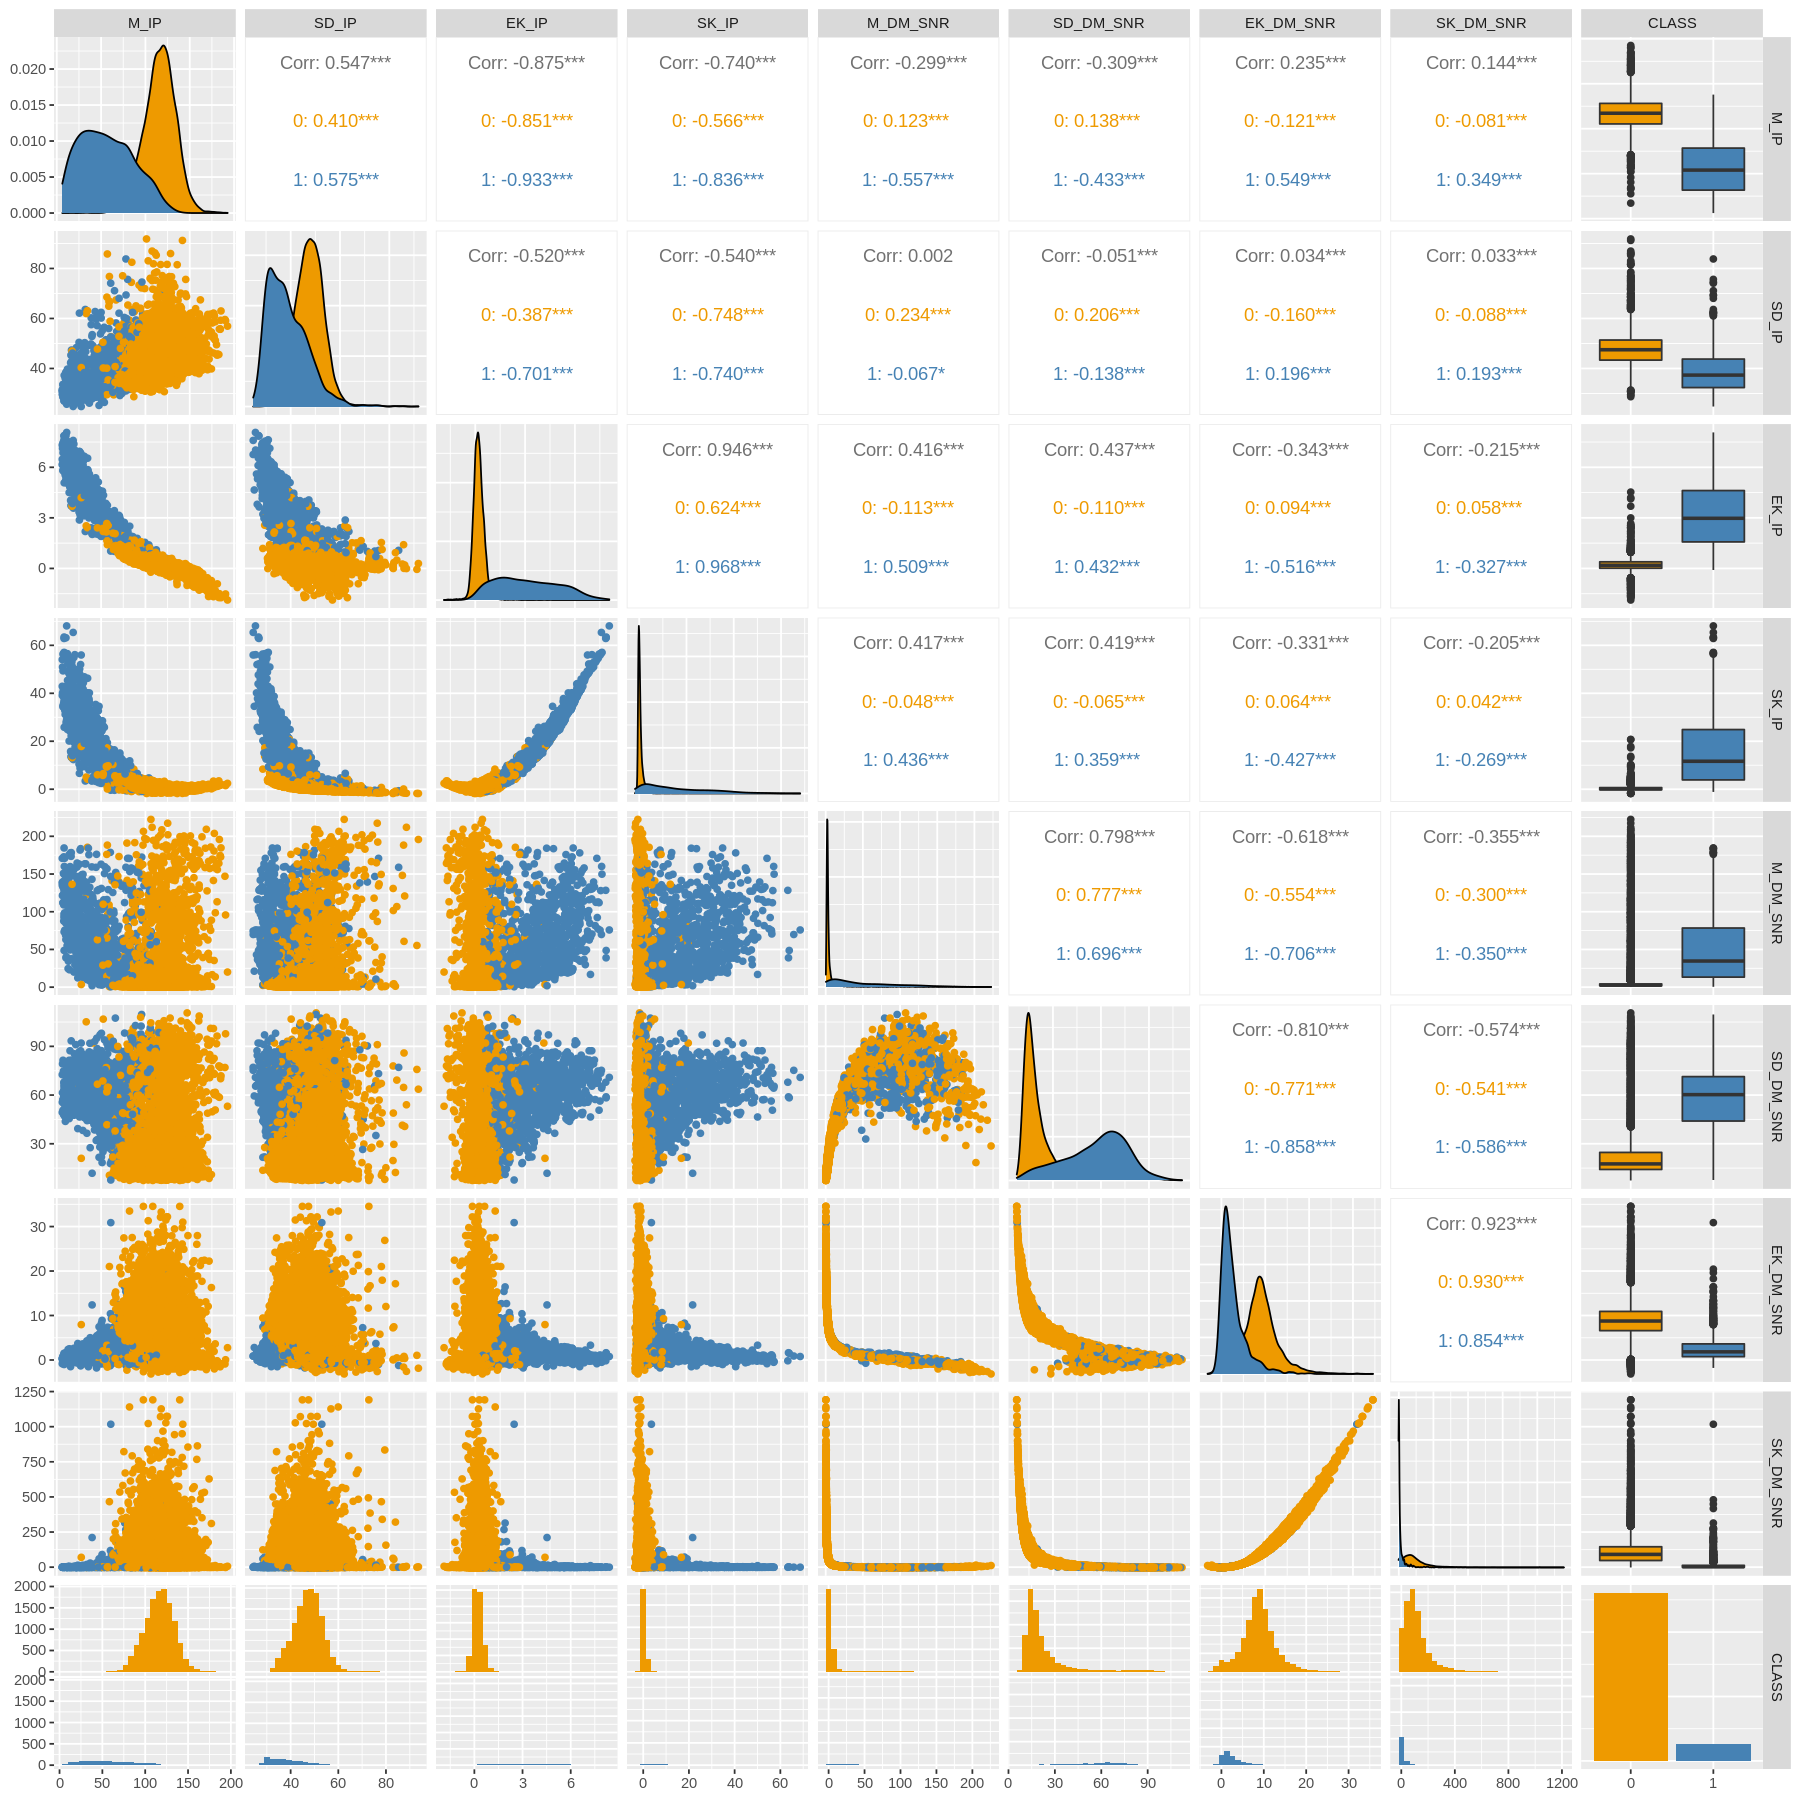

In [15]:
options(repr.plot.height = 15, repr.plot.width = 15)
pair_plot <- ggpairs(pulsar_train,aes(color = CLASS)) +
                scale_color_manual(labels = c("Non-pulsar", "Pulsar"),
                                  values = c("orange2", "steelblue")) +
                scale_fill_manual(labels = c("Non-pulsar", "Pulsar"),
                                  values = c("orange2", "steelblue"))
pair_plot

In [5]:
# training data is too large for forward selection so we use a smaller subset called pulsar_small_train
set.seed(4)
pulsar_train_split <- initial_split(pulsar_train, prop = 0.3, strata = CLASS)
pulsar_small_train <- training(pulsar_train_split)
pulsar_validation <- testing(pulsar_train_split)

In [11]:
nrow(pulsar_train)
nrow(pulsar_small_train)

[1] 14318

[1] 4295

In [19]:
set.seed(4)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_fwd_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5 fold cross-validation object
pulsar_fwd_vfold <- vfold_cv(pulsar_small_train, v = 5, strata = CLASS)

# names of predictors
names <- colnames(pulsar_small_train |>
                     select(-CLASS)) 

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("CLASS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_fwd_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_small_train) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors()) |>
                            step_upsample(CLASS, over_ratio = 1)

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(pulsar_fwd_recipe) |>
          add_model(knn_fwd_spec) |>
          tune_grid(resamples = pulsar_fwd_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,CLASS ~ EK_IP,0.9632130
2,CLASS ~ EK_IP+SD_IP,0.9701979
3,CLASS ~ EK_IP+SD_IP+M_DM_SNR,0.9718277
⋮,⋮,⋮
6,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR,0.9683353
7,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR,0.9683353
8,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR+EK_DM_SNR,0.9678696


In [20]:
print(accuracies)

# A tibble: 8 × 3
   size model_string                                                    accuracy
  <int> <chr>                                                              <dbl>
1     1 CLASS ~ EK_IP                                                      0.963
2     2 CLASS ~ EK_IP+SD_IP                                                0.970
3     3 CLASS ~ EK_IP+SD_IP+M_DM_SNR                                       0.972
4     4 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP                                 0.973
5     5 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP                            0.971
6     6 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR                  0.968
7     7 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR        0.968
8     8 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR+EK…    0.968


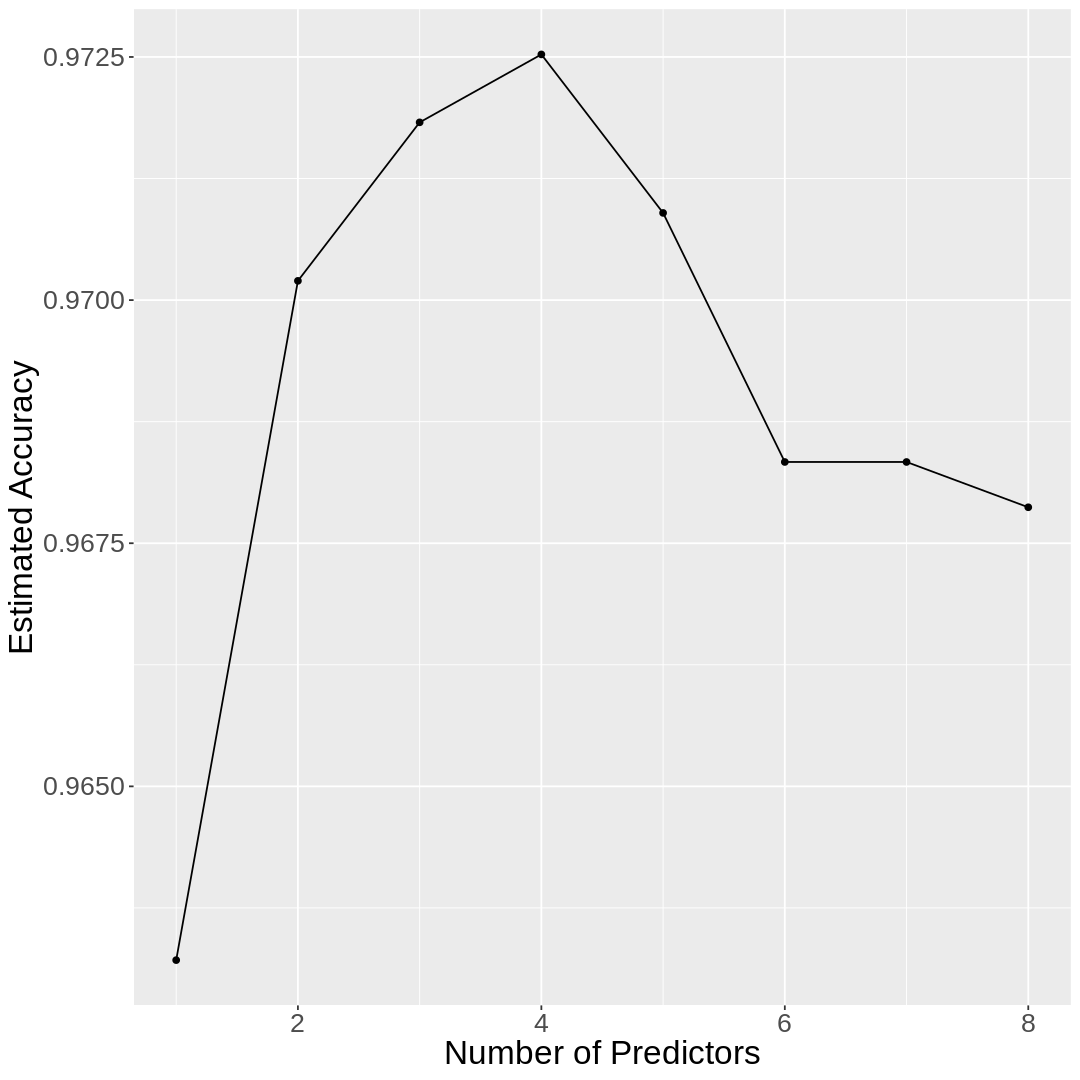

In [21]:
options(repr.plot.height = 9, repr.plot.width = 9)
accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Predictors", y = "Estimated Accuracy") +
                    theme(text = element_text(size = 20))
accuracies_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9709457,5,0.0009709794,Preprocessor1_Model01
2,accuracy,binary,0.9709457,5,0.0009709794,Preprocessor1_Model02
3,accuracy,binary,0.9643109,5,0.0014860142,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.9585833,5,0.001954190,Preprocessor1_Model28
29,accuracy,binary,0.9592819,5,0.001666928,Preprocessor1_Model29
30,accuracy,binary,0.9592819,5,0.001666928,Preprocessor1_Model30


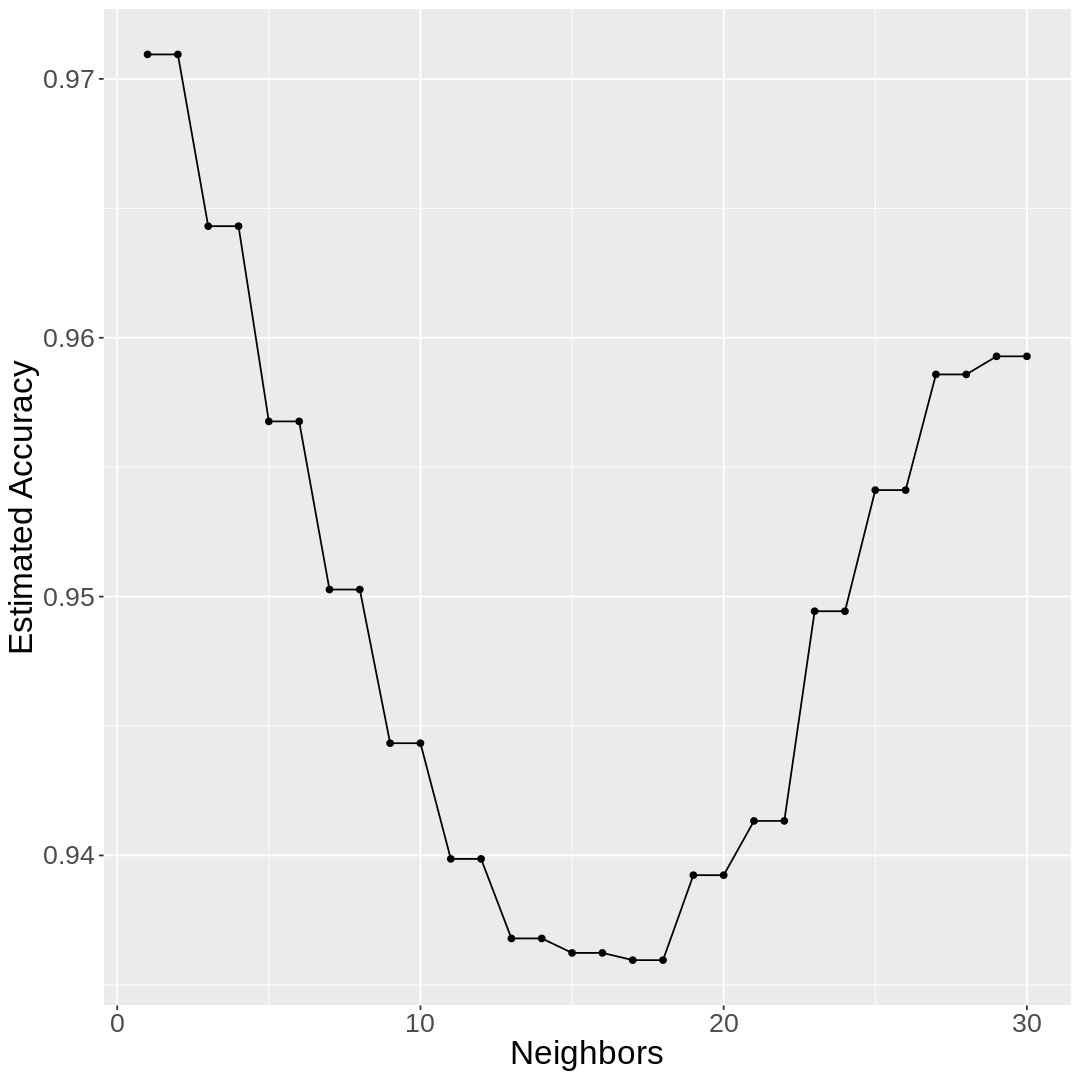

In [6]:
set.seed(4)
# create a model specification
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

# create a model recipe using the predictor variables as given from forward selection
pulsar_recipe_tune <- recipe(CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP, data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(CLASS, over_ratio = 1)

# make a 5 fold cross-validation object using entire training dataset
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = CLASS)

# grid of neighbor values
grid_vals <- tibble(neighbors = seq(1:30))

# fit the model onto the training data and collect estimated accuracy vs neighbors data
pulsar_eaccuracy <- workflow() |>
                add_recipe(pulsar_recipe_tune) |>
                add_model(knn_tune_spec) |>
                tune_grid(resamples = pulsar_vfold, grid = grid_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")
pulsar_eaccuracy

estimate_accuracy_vs_k <- ggplot(pulsar_eaccuracy, aes(x = neighbors, y = mean)) +
                            geom_point() +
                            geom_line() +
                            labs(x = "Neighbors", y = "Estimated Accuracy") +
                            theme(text = element_text(size = 20))
estimate_accuracy_vs_k

In [7]:
set.seed(4)
# create a new model specification using the best neighbor value
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
                set_engine("kknn") |>
                set_mode("classification")

# we can reuse the old recipe, but we are creating a new one so that this code block can be run seperately
pulsar_recipe <- recipe(CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP, data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(CLASS, over_ratio = 1)

# fir model onto the training data
pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_best_spec) |>
                fit(pulsar_train) 

# predict labels for test data observations and join with original table
pulsar_predict <- predict(pulsar_fit, pulsar_test) |>
                    bind_cols(pulsar_test)

# Calculate accuracy of our model predicting on testing data
pulsar_accuracy <- pulsar_predict |>
                    metrics(truth = CLASS, estimate = .pred_class)
pulsar_accuracy

# confusion matrix for our model predicting on testing data
pulsar_conf_mat <- pulsar_predict |>
                    conf_mat(truth = CLASS, estimate = .pred_class)

pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9592179
kap,binary,0.7701358


          Truth
Prediction    0    1
         0 3155   47
         1   99  279

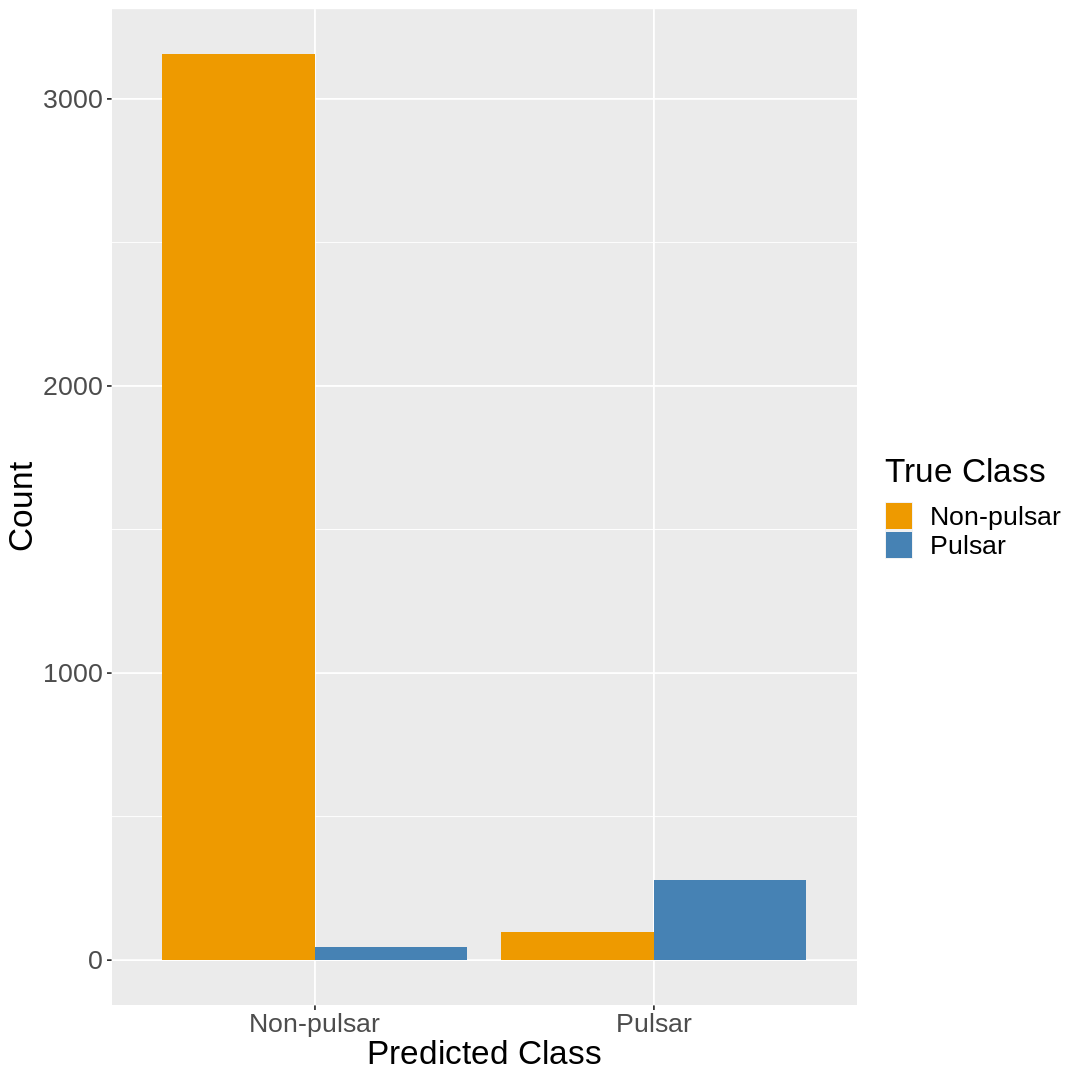

In [9]:
confusion_matrix_data <- tibble(Prediction = (as.factor(c(0,0,1,1))),
                           Truth = (as.factor(c(0,1,0,1))),
                           count = c(3155, 47, 99, 279))
confusion_matrix_plot <- ggplot(confusion_matrix_data, aes(x = Prediction, y = count, fill = Truth)) +
                            geom_bar(stat = "identity", position = "dodge") +
                            labs(x = "Predicted Class", y = "Count", fill = "True Class") +
                            scale_fill_manual(labels = c("Non-pulsar", "Pulsar"),
                                             values = c("orange2", "steelblue")) +
                            scale_x_discrete(labels = c("0" = "Non-pulsar",
                                                       "1" = "Pulsar")) +
                            theme(text = element_text(size = 20))
confusion_matrix_plot

EXPECTED OUTCOMES AND SIGNIFICANCE:

Given measurements for some of the characteristics of the integrated profile and DM-SNR curves, we expect to be able to predict whether a radio signal is a pulsar or not.

Pulsars are integral for scientific discovery; they help us in studying extreme states of matter, planetary searches and measuring distances outside of earth. So far, we have only identified about 2000 pulsars. Owing to their necessity in scientific research, finding more pulsars becomes crucial.

Usually, a researcher must manually classify each observation, but this is quite time-consuming. If our classifier can successfully classify pulsars, it would accelerate this process significantly and hence accelerate scientific discovery.

If our classifier works, we can further try and answer the following questions:

1.Which characteristics of the integrated profile and DM-SNR curve differentiate pulsars from non-pulsar radio signals?

2.Can we make classifiers to identify other interstellar objects?

3.Can pulsars be differentiated into subtypes?

Reference list:

https://archive.ics.uci.edu/ml/datasets/HTRU2

Data Science A First Introduction by Tiffany Timbers, Trevor Campbell, and Melissa Lee.

D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005.

https://www.space.com/32661-pulsars.html

https://en.wikipedia.org/wiki/Pulsar
